In [1]:
using Meiran, Tonari, LinearAlgebra
using Random,Plots
using FFTW

## I. Modelling

Define the cross-spectral model

In [2]:
𝓟₁ = SingleBendingPowerLaw(1.0, .30, 4e-2, 3.5)
𝓟₂ = SingleBendingPowerLaw(1.0, .30, 4e-2, 3.5)
Δϕ = ConstantTimeLag(5.35)
cs = CrossSpectralDensity(𝓟₁, 𝓟₂, Δϕ)

CrossSpectralDensity(SingleBendingPowerLaw{Float64}(1.0, 0.3, 0.04, 3.5), SingleBendingPowerLaw{Float64}(1.0, 0.3, 0.04, 3.5), ConstantTimeLag(5.35))

Define the time series duration and sampling

In [3]:
T, Δt = 120., 1.
t = 0:Δt:T;

f_min = 1. / T
f_max = 1. / Δt / 2;

Define the approximation settings

In [4]:
# number of basis functions
J = 100
# define the extended frequency range for the approximation
f0, fM = f_min / 10, f_max * 10
# define the grid of basis functions
fⱼ = 10 .^ range(log10(f_min), log10(f_max), length = J);

Compute the amplitude, centroids, widths of the basis functions to approximate  the cross-spectral density

In [5]:
fⱼ, ωⱼ, zⱼ, a_𝓟₁, a_𝓟₂, a_𝓒₁₂, a_τ =  approximate_cross_spectral_density(cs, f0, fM, J);

## II. Check the approximation

In [6]:
rect(x) = float(abs.(x) .< 0.5 );

### II. 1. Power spectral density and covariance function

#### II. 1. a. Power spectral density
Comparison of the true power spectral model and approximation with top-hats

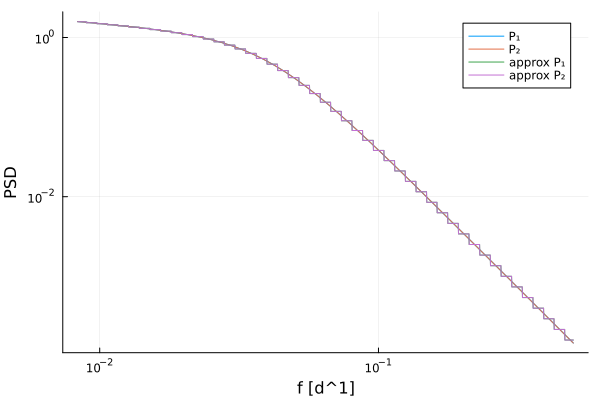

In [7]:
f = 10 .^ range(log10(f_min), log10(f_max), length = 2000);
M = length(f);
approx_𝓟₁ = zeros(M)
approx_𝓟₂ = zeros(M)
for j in 1:J
	approx_𝓟₁ += a_𝓟₁[j] * rect((f .- zⱼ[j]) ./ ωⱼ[j])
	approx_𝓟₂ += a_𝓟₂[j] * rect((f .- zⱼ[j]) ./ ωⱼ[j])

end

plot(f, 𝓟₁(f), xscale = :log10, yscale = :log10, label = "P₁", xlabel = "f [d^1]", ylabel = "PSD")
plot!(f, 𝓟₂(f), label = "P₂")
plot!(f, approx_𝓟₁, label = "approx P₁")
plot!(f, approx_𝓟₂, label = "approx P₂")


#### II. 1. b. Covariance function

Compare the covariance function of the true model and the approximation

We must first evaluate the true power spectral density on a regular grid

In [8]:
f_reg = collect(f0:f0:fM)
M = length(f_reg)
approx_𝓟₁ = zeros(M)
approx_𝓟₂ = zeros(M)
for j in 1:J
	approx_𝓟₁ += a_𝓟₁[j] * rect((f_reg .- zⱼ[j]) ./ ωⱼ[j])
	approx_𝓟₂ += a_𝓟₂[j] * rect((f_reg .- zⱼ[j]) ./ ωⱼ[j])

end

We then take the inverse Fourier transform of the power spectral density to obtain the covariance function


In [9]:
Δτ = 1 / (2fM)
tau = range(0, step = Δτ, length = M)
R_fft_1 = irfft([0.0; approx_𝓟₁], 2 * M)[1:M] / Δτ;
R_fft_model_1 = irfft([0.0; 𝓟₁(f_reg)], 2 * M)[1:M] / Δτ;

τ = LinRange(0, tau[end], 200)
R₁ = Cross_Cov = approximated_covariance(tau, a_𝓟₁, ωⱼ, zⱼ, J);

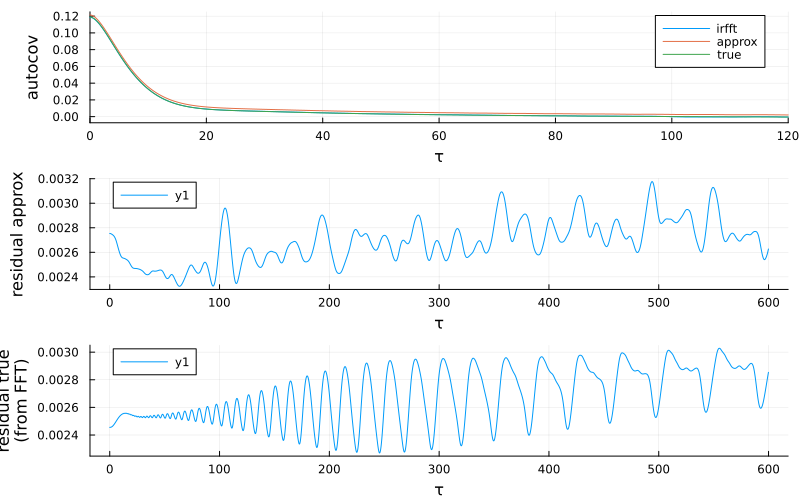

In [10]:
l = @layout [a; b; c]
p1 = plot(tau, R_fft_1, label = "irfft")
p1 = plot!(tau, R₁, label = "approx", ylabel = "autocov", xlabel = "τ")
p1 = plot!(tau, R_fft_model_1, label = "true", xlims = (0, 120), ylabel = "autocov", xlabel = "τ")
p2 = plot(tau,  approximated_covariance(tau, a_𝓟₁, ωⱼ, zⱼ, J)- R_fft_1, ylabel = "residual approx", xlabel = "τ")
p3 = plot(tau,  approximated_covariance(tau, a_𝓟₁, ωⱼ, zⱼ, J)- R_fft_model_1, ylabel = "residual true\n(from FFT)", xlabel = "τ")
plot(p1, p2, p3, layout = l, size = (800, 500))

### II. 2. Cross-spectral density and cross-covariance

#### II. 2. a. Cross-spectral density

Compute the cross-spectrum approximation on a regular grid of frequencies

In [11]:
f = f0:f0:fM
M = length(f);
approx_𝓒₁₂ = zeros(M)
for j in 1:J
	approx_𝓒₁₂ += a_𝓒₁₂[j] .* rect((f .- zⱼ[j]) ./ ωⱼ[j]) .* exp.(im*2π .*f*a_τ[j])
end

We can check that the amplitude of the cross-spectrum is well approximated

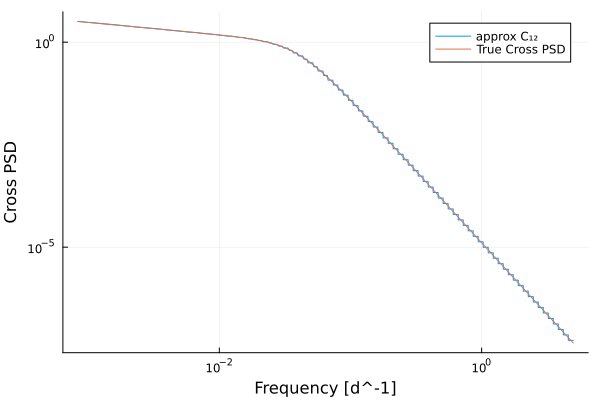

In [12]:
plot(f,abs.(approx_𝓒₁₂),xscale=:log10,label="approx C₁₂",yscale=:log10)
plot!(f,sqrt.(𝓟₁(f).*𝓟₂(f)),xlabel="Frequency [d^-1]",ylabel="Cross PSD",label="True Cross PSD")

The time lag and phase of the cross-spectrum are also well approximated

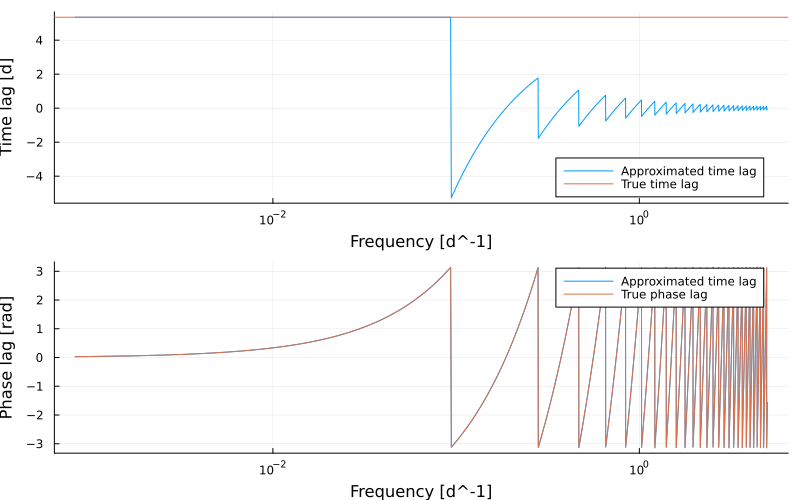

In [13]:
l = @layout [a; b]
p1 = plot(f,angle.(approx_𝓒₁₂)/2π./f,xscale=:log10,xlabel="Frequency [d^-1]",ylabel="Time lag [d]",label="Approximated time lag")
p1 = hline!([cs.Δφ.Δτ],label="True time lag")
p2 = plot(f,angle.(approx_𝓒₁₂),xscale=:log10,xlabel="Frequency [d^-1]",ylabel="Phase lag [rad]",label="Approximated time lag")
p2 = plot!(f,[mod2pi.(cs.Δφ.Δτ*2π .*f.+π).-π],label="True phase lag")
plot(p1,p2,layout=l,size=(800,500))

Now we prepare the data to apply the inverse Fourier transform to obtain the cross-covariance function. We have to add the negative frequencies to the cross-spectrum as the cross-spectrum is not real and even.

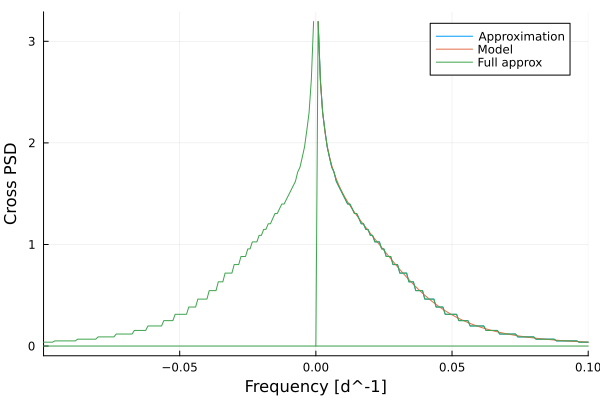

In [14]:
approx_𝓒₁₂_full = [imag(approx_𝓒₁₂[1])*im*0; approx_𝓒₁₂ ; conj.(reverse(approx_𝓒₁₂[1:end]))];
freqs = fftfreq(length(approx_𝓒₁₂_full),2fM)

plot(f,abs.(approx_𝓒₁₂),label="Approximation")
plot!(f,sqrt.(𝓟₂(f).*𝓟₁(f)),label="Model")
plot!(freqs,abs.(approx_𝓒₁₂_full),xlims=(-.1,.1),label="Full approx",xlabel="Frequency [d^-1]",ylabel="Cross PSD")

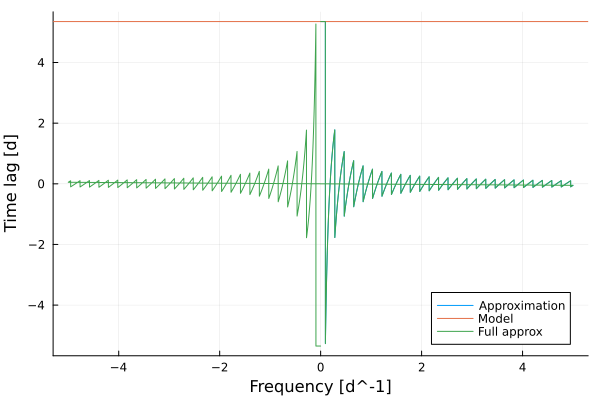

In [15]:
plot(f,angle.(approx_𝓒₁₂)/2π./f,label="Approximation")
hline!([cs.Δφ.Δτ],label="Model")
plot!(freqs,angle.(approx_𝓒₁₂_full)/2π ./abs.(freqs),label="Full approx",
xlabel="Frequency [d^-1]",ylabel="Time lag [d]")

#### II. 2. b. Cross-covariance

We can compute the cross-covariance function and compare it with the true cross-covariance function

In [16]:
𝓒₁₂ = .√𝓟₁(f).* .√𝓟₂(f).* exp.(im*2π*Δϕ(f).*f) 
𝓒₁₂_full = [ imag(𝓒₁₂[1])*im*0. ; 𝓒₁₂ ; conj.(reverse(𝓒₁₂))];

We take the inverse Fourier transform of the cross-spectrum to obtain the cross-covariance function

In [17]:
Δτ = 1/(fM)/2
R_fft = ifft(approx_𝓒₁₂_full) /Δτ;
R_fft_model = ifft(𝓒₁₂_full) /Δτ;
tau = fftfreq(length(R_fft),Δτ*length(R_fft));

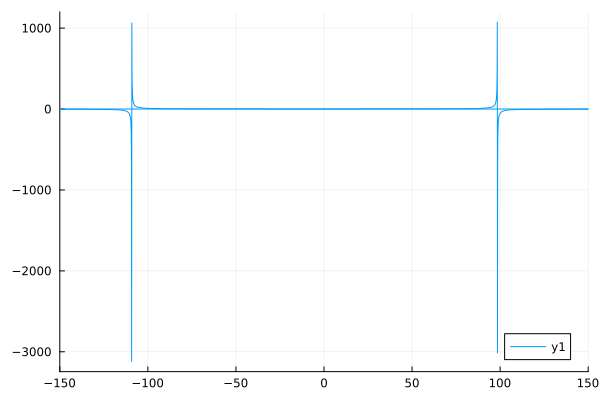

In [18]:
plot(tau,real(approximated_cross_covariance(tau, a_𝓒₁₂, a_τ, ωⱼ, zⱼ, J)./R_fft_model),xlims=(-150,150))

**IMPORTANT**

There is a discrepancy in the normalisation of the cross-covariance function and I don't know why. I will investigate this further. This may be due to the normalisation of IFFT...

In [19]:
τ = sort(unique((t .- t')));

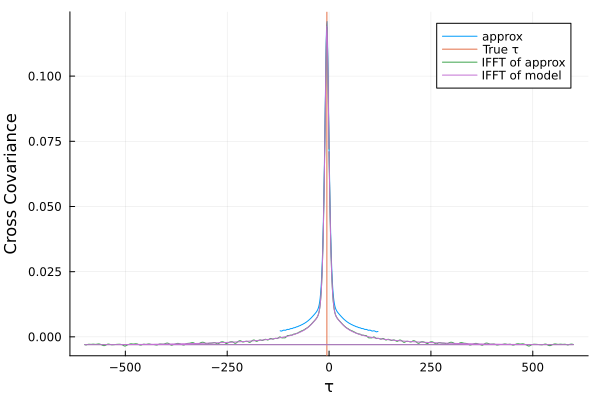

In [20]:
Cross_Cov = approximated_cross_covariance(τ, a_𝓒₁₂, a_τ, ωⱼ, zⱼ, J)

plot(τ, Cross_Cov, xlabel = "τ", ylabel = "Cross Covariance", label = "approx")
vline!([-cs.Δφ(0.)], label = "True τ")#,xlims=(-100,100))
plot!(tau, real.(R_fft), label = "IFFT of approx", xlabel = "τ", ylabel = "Cross Covariance")
plot!(tau, real.(R_fft_model), label = "IFFT of model", xlabel = "τ", ylabel = "Cross Covariance")

## III. Covariance Matrices and Cross-Covariance Matrices

### III. 1. Initialisation

We can now compute the covariance matrices and the cross-covariance matrix. We will assume two different time stamps for the two time series.

In [21]:
T₁,T₂ = 120., 95.4
Δt₁,Δt₂ = 0.6,1.1  
t₁ = 0:Δt₁:T₁
t₂ = 0:Δt₂:T₂;

We now populate the covariance matrices and the cross-covariance matrix

In [22]:
d₁ = (t₁ .- t₁')
d₂ = (t₂ .- t₂')
d₁₂ = t₁ .- t₂'
Σ₁₁ = approximated_covariance(d₁, a_𝓟₁, ωⱼ, zⱼ, J)
Σ₂₂ = approximated_covariance(d₂, a_𝓟₂, ωⱼ, zⱼ, J)
Σ₁₂ = approximated_cross_covariance(d₁₂, a_𝓒₁₂, a_τ, ωⱼ, zⱼ, J)
Σ₂₁ = Σ₁₂';

# we can check the size of the matrices
println(size(Σ₁₁), size(Σ₁₂), size(Σ₂₁), size(Σ₂₂))

(201, 201)(201, 87)(87, 201)(87, 87)


### III. 2. Check the covariance matrices

We can check for positive definiteness of the covariance matrices

In [23]:
isposdef(Σ₁₁),isposdef(Σ₂₂)

(true, true)

The Schur complement of the $\Sigma$ is given by $S = \Sigma_{22} - \Sigma_{21} \Sigma_{11}^{-1} \Sigma_{12}$

It should be symmetric and positive definite


In [24]:
S = (Σ₂₂ - (Σ₂₁ * inv(Σ₁₁) * Σ₁₂))
println("S is approximately symmetric: ",S ≈ S',"\nS is positive definite: ",isposdef(S))

S is approximately symmetric: true
S is positive definite: false


We can ensure positive definiteness by making the matrix positive definite

In [25]:
S = Symmetric((S+S')/2);
println("S is positive definite: ",isposdef(S))

S is positive definite: true


Its inverse should also be positive definite

In [26]:
isposdef(inv(S))

true

### III. 3. Plot the matrices

Covariance matrix

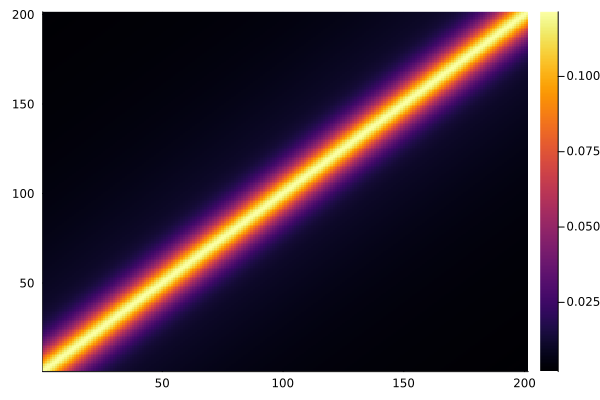

In [27]:
heatmap(Σ₁₁)

Cross-covariance matrix

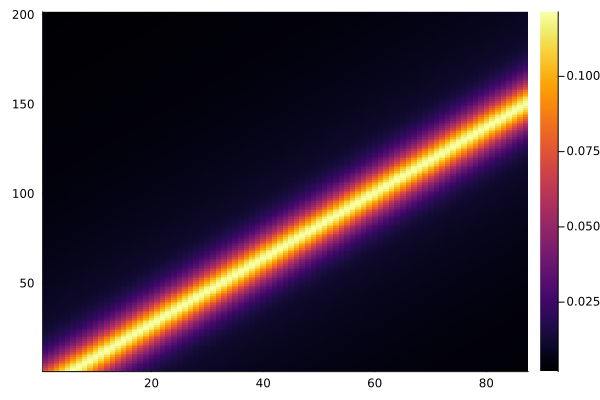

In [28]:
heatmap(Σ₁₂)

Schur complement

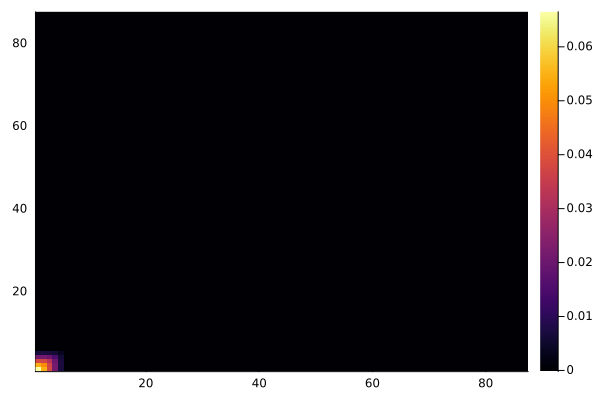

In [29]:
heatmap(Matrix(S))